In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
from torchsummary import summary

import numpy as np
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [17]:
class VisionTransformer(nn.Module):

    def __init__(self, batch_size, num_classes, dim, depth, heads, mlp_dim, output_dim, img_dim = [3,224,224], patch_dim = [3,56,56], dim_head = 64):
        super().__init__()
        image_h = img_dim[1]
        image_w = img_dim[2]
        patch_h = patch_dim[1]
        patch_w = patch_dim[2]

        n_patches = (image_h // patch_h) * (image_w // patch_w)
        embedding_dim = img_dim[0] * patch_h * patch_w

        self.patch_dim = patch_dim
        self.img_dim = img_dim
        self.batch_size = batch_size
        self.n_patches = n_patches
        self.embedding_dim = embedding_dim

        #so we flatten the patches and map to D dimensions with a trainable linear projection (Eq. 1).
        self.projection = nn.Sequential(     
            nn.LayerNorm(embedding_dim),                            #layernorm에 대한 언급은 못찾겠음
            nn.Linear(embedding_dim, dim),
            nn.LayerNorm(dim)
        )
        self.cls_token =nn.Parameter(torch.randn(1, dim))
        self.pos_embedding =nn.Parameter(torch.randn(n_patches+1, dim))

        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.classification_head = nn.Linear(dim, output_dim)
        self.norm = nn.LayerNorm(output_dim)


    def forward(self, img):
        channels=img.shape[1]

        x = img.unfold(2, self.patch_dim[1], self.patch_dim[2]).unfold(3, self.patch_dim[1], self.patch_dim[2])
        x = x.contiguous().view(self.batch_size, channels, self.n_patches, self.patch_dim[1], self.patch_dim[2])
        patches = x.permute(0, 2, 3, 4, 1)
        x = patches.contiguous().view(self.batch_size, self.n_patches, self.embedding_dim)
        x = self.projection(x)

        cls_tokens = self.cls_token.repeat(self.batch_size, 1, 1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.pos_embedding

        x = self.transformer(x)
        x = x[:,0]

        x = self.classification_head(x)
        x = self.norm(x)                    #is this order right?
        #많은 구현체에서 norm순서나 유무 vatiation이 많았다

        return x

In [18]:
class Attention(nn.Module):
    def __init__(self, dim, heads = 8):
        super().__init__()
        self.dim = dim
        self.dim_heads = dim // heads
        self.norm = nn.LayerNorm(dim)
        self.to_qkv = nn.Linear(dim, dim * 3)
        self.MHA = nn.MultiheadAttention(dim, heads, batch_first=True)       #dim means input sequence's dim

    def forward(self, x):
        x = self.norm(x)
        qkv = self.to_qkv(x).chunk(3, dim=-1)   #example: https://pytorch.org/docs/stable/generated/torch.chunk.html
        q, k, v = [token for token in qkv]
        result = self.MHA(q,k,v, need_weights=True)[0]
        return result


In [19]:
class FeedForward(nn.Module):
    def __init__(self, dim, mlp_dim):
        super().__init__()
        layers = []
        layers.append(nn.LayerNorm(dim))
        layers.append(nn.Linear(dim, mlp_dim))
        layers.append(nn.GELU())
        layers.append(nn.Linear(mlp_dim, dim))
        self.net = nn.Sequential(*layers)

    def forward(self,x):
        return self.net(x)

In [20]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):       #in paper head_dim = dim * 4
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = []
        for _ in range(depth):
            self.layers.append([(Attention(dim, heads)),(FeedForward(dim, mlp_dim))])

    def forward(self,x):
        for attn, ffn in self.layers:
            x = attn(x) + x
            x = ffn(x) + x
        return self.norm(x)
        

In [24]:
model = VisionTransformer(batch_size=16, num_classes=10, dim=64, depth=8, heads=64, mlp_dim=256, output_dim=1000)

In [25]:
x = torch.randn([16,3,224,224])    #(b,c,h,w)
y = model(x)

In [26]:
print(x.shape)
print(y.shape)

torch.Size([16, 3, 224, 224])
torch.Size([16, 1000])


## patch test

In [103]:
import cv2

In [104]:
img = cv2.imread("../temp.jpg")
img = cv2.resize(img, dsize = (224,224))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img.reshape(224,224,3)

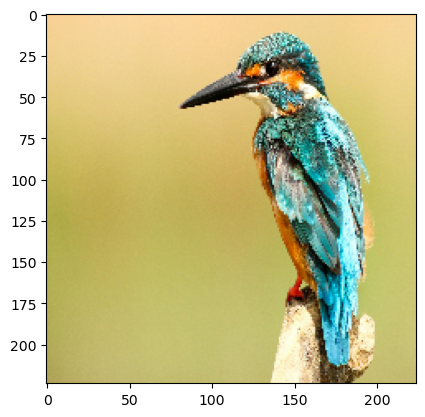

In [105]:
plt.imshow(img)

In [106]:
img.shape

(224, 224, 3)

In [107]:
img = torch.tensor(img).permute(2,0,1).reshape(1,3,224,224)

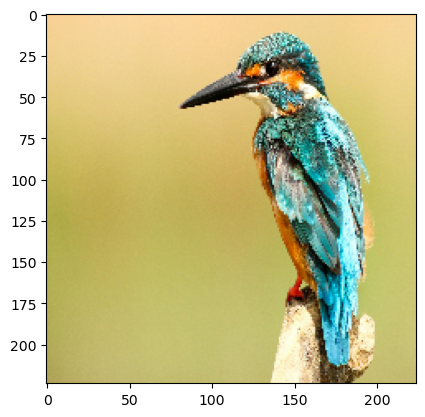

In [108]:
plt.imshow(img[0].permute(1,2,0))

In [109]:
model = VisionTransformer(batch_size=1, num_classes=10, dim=64, depth=8, heads=64, mlp_dim=256)
y = model(img)
y = y.reshape(1,16,56,56,3)

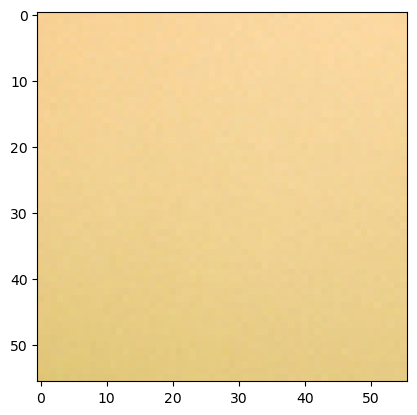

In [110]:
plt.imshow(y[0][0])

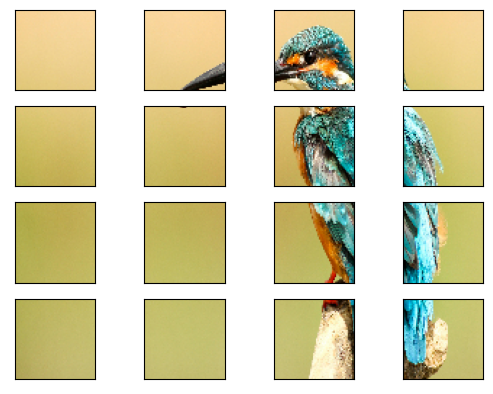

In [111]:
fig, axes = plt.subplots(4,4)
axes = axes.flatten()
for i in range(16):
    axes[i].axes.xaxis.set_ticks([])
    axes[i].axes.yaxis.set_ticks([])
    axes[i].imshow(y[0][i])    